In [38]:
ERR_P = 0.1
ERR_N = 0.1

class PreProcessor:
    "Add noise to reward"
    def __init__(self, e_=0.1, e=0.3, normal=True, epsilon=1e-6):
        assert (np.abs(e_ + e - 1) > epsilon)
        self.normal = normal
        self.e_ = e_
        self.e = e
        self.epsilon = 1e-6
        # These are the noisy returns that are returned
        self.r1 = -1
        self.r2 = 0

    def noisy_reward(self, reward):
        n = np.random.random()
        # If we hit a negative reward, conver it to a poisitive
        # with a given prob. 
        # Not sure why the `< epsilone is here`
        # if np.abs(reward - self.r1) < self.epsilon:
        if reward == self.r1:
            if (n < self.e_):
                return self.r2
        else:
            if (n < self.e):
                return self.r1
        return reward

    def process_reward(self, reward):
        if self.normal:
            return reward

        r = self.noisy_reward(reward)
        return r
    
pre_processor = PreProcessor(normal=False, e_=ERR_N, e=ERR_P)

In [24]:
all_chart_values = []

In [32]:
# Run the script with
# `python run_experiment.py -t 1`
# This will run a simulation trial, with a total length of 1 seconds.
# Participant answere will be given every 0.001 to 0.002 seconds.
# The participant "ture" level of feedback is 2.

# The script will output:
# - A list of actions taken, in the format: 
# `elapsed_time > action_taken -> reward_received`
# - The Q-table at the end of the trial,
# with rows representing states and columns representing acions
# - The total count of given actions taken in a given state, 
# with rows representing states and columns representing acions
# - Total timesteps (actions) taken
# - Total reward obtained

# The agent is rewrded `-1` for guessing the wrong feedback level (not 2),
# and `0` for guessing correctly

import argparse
from ucbq_agent import UCBQAgent
from ucbq_environment import ModifiedRandomEnvironment
import time
import numpy as np

# parser = argparse.ArgumentParser()
# parser.add_argument("-t", "--TimeOut", help = "Stop script after n seconds")
# args = parser.parse_args()
timeOut = 30

Q-table:
[[-1. -1.  0.]
 [-1. -1.  0.]
 [-1. -1.  0.]]
Number of times action was taken:
[[   17.    17.   483.]
 [   17.    17.   473.]
 [  484.   472. 12752.]]
Total timesteps: 14632.0
Episode rewards: -1018


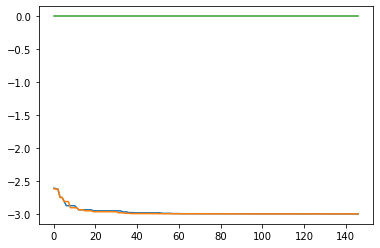

In [36]:
num_states = 3
start_state = 1
agent = UCBQAgent(num_states=num_states, num_actions=num_states)
env = ModifiedRandomEnvironment(current_state = start_state, num_states=num_states)

start_time = time.time()
t = 0

episode_rewards = 0

q_values_for_chart = []

state = start_state

while True:
    elapsed_time = time.time() - start_time

    # Auto shut down scipt 
    if bool(timeOut) and (elapsed_time > float(timeOut)):
        break

    action = agent.choose_action(state) 
    # TODO: 
    # send_action_to_stream
    reward, next_state = env.step(action)
    
    # print(f"{round(elapsed_time, 2)} > {action} -> {reward}")
    
    agent.learn(state, action, reward, next_state)
    state = next_state

    episode_rewards += reward

    t += 1
    if t % 100 == 0:
        q_values_for_chart.append(np.around(np.sum(agent.Q, axis=0), decimals=4))

print(f'Q-table:')
print(f'{np.around(agent.Q, decimals=4)}')
print(f'Number of times action was taken:')
print(f'{agent.N}')
print(f'Total timesteps: {sum(sum(agent.N)) - 100}')
print(f'Episode rewards: {episode_rewards}')

import matplotlib.pyplot as plt
plt.plot(q_values_for_chart)

all_chart_values.append(q_values_for_chart)

# Noisy rewards

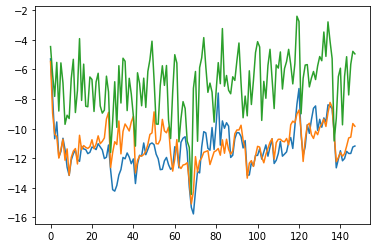

In [39]:
agent = UCBQAgent(num_states=num_states, num_actions=num_states)
env = ModifiedRandomEnvironment(current_state = start_state, num_states=num_states)

start_time = time.time()
t = 0

episode_rewards = 0

q_values_for_chart = []

state = start_state

while True:
    elapsed_time = time.time() - start_time

    # Auto shut down scipt 
    if bool(timeOut) and (elapsed_time > float(timeOut)):
        break

    action = agent.choose_action(state) 
    reward, next_state = env.step(action)

    reward = pre_processor.process_reward(reward)
    
    # print(f"{round(elapsed_time, 2)} > {action} -> {reward}")
    
    agent.learn(state, action, reward, next_state)
    state = next_state

    episode_rewards += reward

    t += 1
    if t % 100 == 0:
        q_values_for_chart.append(np.around(np.sum(agent.Q, axis=0), decimals=4))

plt.plot(q_values_for_chart)

all_chart_values.append(q_values_for_chart)

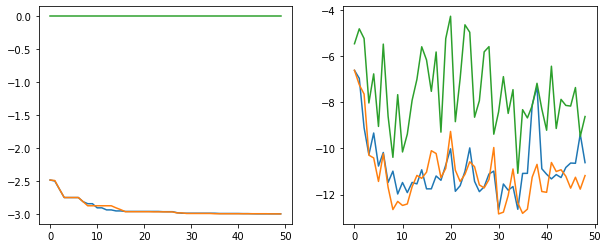

In [35]:
fig = plt.gcf()
fig.set_size_inches(10, 4)
plt.subplot(1, 2, 1)
plt.plot(all_chart_values[0])
plt.subplot(1, 2, 2)
plt.plot(all_chart_values[1])
